# Deep Learning: Konsep dan Aplikasi Geospasial

**Bagian 2: Deep learning pada bidang Geospasial**

Pada bagian kedua ini kita akan melihat bagaimana Konsep Deep Learning diimplementasikan untuk melakukan klasifikasi dari data citra satelit. Perlu diingat bahwa model klasifikasi yang dilakukan pada notebook ini adalah Object Recognition, atau identifikasi objek. Untuk aplikasi berupa Semantic Segmentation, Anda dipersilahkan untuk merujuk pada contoh yang diberikan di bagian rujukan di bawah Notebook ini.

## Pengantar

Pada latihan ini kita akan menggunakan data [Landuse Dataset](http://weegee.vision.ucmerced.edu/datasets/landuse.html) dari University of California, Merced. Data ini terdiri dari masing-masing 100 gambar untuk tiap kelas berikut:

```
agricultural
airplane
baseballdiamond
beach
buildings
chaparral
denseresidential
forest
freeway
golfcourse
harbor
intersection
mediumresidential
mobilehomepark
overpass
parkinglot
river
runway
sparseresidential
storagetanks
tenniscourt
```

ukuran tiap gambar adalah 256x256, dengan resolusi tiap gambar adalah 0.3 meter. Data ini merupakan salah satu data yang populer digunakan untuk keperluan Deep Learning, meskipun memiliki beberapa kekurangan pada perbedaan ukuran piksel yang disediakan.

![](https://www.researchgate.net/publication/324924412/figure/fig4/AS:644015246544898@1530556608631/Example-images-from-the-UC-Merced-dataset.png)

Pada Latihan ini kita akan membangun model CNN menggunakan Keras dan Tensorflow, kemudian membagi data tersebut menjadi data untuk Uji dan data Training. Selanjutnya kita akan melihat bagaimana melakukan evaluasi pada data tersebut menggunakan Metrics yang disediakan oleh Keras.

## Unduh Data

Set data Landuse dari UC Merced dapat diunduh dari websitenya secara langsung. Kita akan menggunakan perintah Linux untuk keperluan ini.

In [1]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

--2021-02-27 07:34:45--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M   103MB/s    in 4.3s    

2021-02-27 07:34:50 (73.7 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



Periksa pada bagian kanan dari notebook Anda. Pastikan bahwa data tersebut telah diunduh. 

Selanjutnya, lakukan Unzip:

In [2]:
!unzip UCMerced_LandUse.zip 

Archive:  UCMerced_LandUse.zip
   creating: UCMerced_LandUse/Images/
   creating: UCMerced_LandUse/Images/agricultural/
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural04.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural05.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural06.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural07.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural08.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural09.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural10.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural11.tif  
  inflating: UCMerced_LandUs

Sekali lagi periksa Google Drive notebook Anda untuk memastikan bahwa proses Unzip telah berhasil. 

## Persiapan dan Preprocessing Data

Sebelum lebih lanjut membuat model dan melakukan training, kita terlebih dahulu perlu memproses citra yang akan digunakan. Hal ini karena kita perlu merubah dimensi dari data yang kita miliki agar dapat digunakan pada layer pertama model yang akan kita bangun.


In [4]:
# inisiasi
from PIL import Image #import Python Image Library: untuk manajemen gambar sederhana
import numpy as np
import os
import glob
import re

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Sekali lagi kita gunakan perintah Linux untuk keperluan ini:

In [5]:
dirs = os.listdir('./UCMerced_LandUse/Images/') #Apa isi folder ini?
for i in dirs: #loop semua directory
  print(i)

airplane
baseballdiamond
storagetanks
beach
sparseresidential
harbor
runway
denseresidential
river
overpass
intersection
mobilehomepark
buildings
tenniscourt
chaparral
agricultural
freeway
parkinglot
golfcourse
mediumresidential
forest


Di sinilah kita melakukan pre-processing data. Langkah ini diperlukan pada setiap training model deep learning untuk memastikan bahwa hanya data yang baiklah yang akan kita gunakan sebagai training.

In [7]:

# membuat fungsi untuk membaca dan memproses citra
def read_img(location):
	x_train = []
	y_train = []
	x_test = []
	y_test = []
	dirs = os.listdir('./UCMerced_LandUse/Images/')
	label = 0
	for i in dirs:
		n = 0
		count = 0
		for pic in glob.glob('./UCMerced_LandUse/Images/'+i+'/*.tif'):
			im = Image.open(pic)
			im = np.array(im)
			if((im.shape[0]==256) and (im.shape[1] == 256) and count <90): # ambil 90 data dari tiap label
				r = im[:,:,0]
				g = im[:,:,1]
				b = im[:,:,2]
				if(n<5): # ambil 5 data pertama di tiap label sebagai data TEST
					x_test.append([r,g,b])
					y_test.append([label])
				else: # gunakan sisa data pada tiap folder sebagai data TRAIN
					x_train.append([r,g,b])
					y_train.append([label])
				n = n + 1
				count = count + 1
		#print(i)
		label = label + 1
	return np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)


Dari seluruh data yang kita miliki, kita bagi menjadi dua:
* train dan train label untuk training
* test dan test label untuk menguji akurasi model yang kita buat

Jumlah yang digunakan untuk training dan testing ditentukan melalui fungsi di atas. kita dapat merubahnya untuk melihat bagaimana data tersebut mempengaruhi hasil akhir dari model.

In [8]:
img_rows = 256
img_cols = 256
num_class = 21
x_train,y_train,x_test,y_test = read_img('UCMerced_LandUse/Images/')

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)

input_shape = (img_rows, img_cols, 3)

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, 21)
y_test = keras.utils.to_categorical(y_test, 21)

In [10]:
# berapa jumlah data yang digunakan?
print(x_train.shape) # jumlah data untuk training
print(y_train.shape) # jumlah label
print(x_test.shape)
print(y_test.shape)

(1785, 256, 256, 3)
(1785, 21)
(105, 256, 256, 3)
(105, 21)


## Membangun Model

Sama seperti latihan sebelumnya, kita akan membangun model pada bagian ini. Perbedaannya, kita akan membangun model yang lebih kompleks: 3 layer dengan masing-masing menggunakan Convolution dan Max Pooling:


In [11]:
# Membuat Model dari Keras
model = Sequential()

# layer pertama
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

# layer kedua
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

# layer ketiga
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(21, activation='softmax'))


In [12]:
# Bagaimana arsitekturnya?
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

Perhatikan bagaimana arsitektur di atas disusun. Juga perhatikan berapa parameter yang akan diadjust oleh model pada saat fitting nantinya. Selanjutnya kita kompilasi model ini agar siap digunakan:

In [13]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])


## Fitting Model dan Interpretasi

Pada bagian inilah kita melakukan training. Perhatikan parameter-parameter yang menyusun fitting model ini:

In [14]:
history = model.fit(x_train, y_train, batch_size=50, epochs=50, verbose=1, validation_data=(x_test, y_test))


Epoch 1/50
36/36 [==============================] - 11s 85ms/step - loss: 4.6938 - accuracy: 0.0656 - val_loss: 2.8795 - val_accuracy: 0.1333
Epoch 2/50
36/36 [==============================] - 3s 70ms/step - loss: 2.7713 - accuracy: 0.1623 - val_loss: 2.5491 - val_accuracy: 0.1810
Epoch 3/50
36/36 [==============================] - 3s 70ms/step - loss: 2.2597 - accuracy: 0.3307 - val_loss: 2.2048 - val_accuracy: 0.4571
Epoch 4/50
36/36 [==============================] - 3s 71ms/step - loss: 1.7853 - accuracy: 0.4997 - val_loss: 2.0747 - val_accuracy: 0.4857
Epoch 5/50
36/36 [==============================] - 3s 70ms/step - loss: 1.3363 - accuracy: 0.6205 - val_loss: 1.9282 - val_accuracy: 0.5048
Epoch 6/50
36/36 [==============================] - 3s 71ms/step - loss: 0.9189 - accuracy: 0.7354 - val_loss: 1.8099 - val_accuracy: 0.5238
Epoch 7/50
36/36 [==============================] - 3s 71ms/step - loss: 0.7321 - accuracy: 0.7705 - val_loss: 1.7382 - val_accuracy: 0.5714
Epoch 8/50
3

Menurut Anda, apakah penurunan loss dan naiknya akurasi cukup signifikan dalam 50 epok?

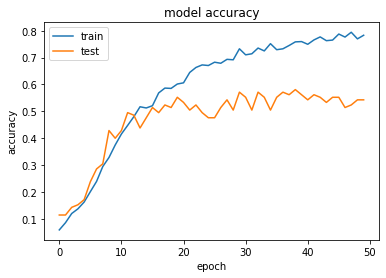

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

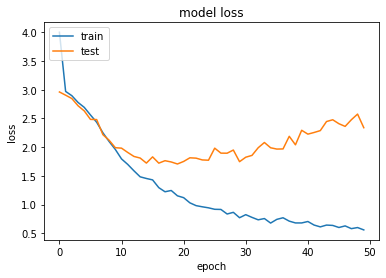

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Testing loss: 2.3380141258239746, acc: 0.5428571701049805



Dari hasil di atas kita peroleh penurunan Loss dan Peningkatan akurasi yang cukup baik. Tetapi apakah model ini cukup akurat digunakan dengan data yang baru?

## Menguji dengan Data Baru

Kita akan coba memanggil data baru untuk diuji. Gunakan data yang telah disediakan atau gunakan data anda sendiri untuk berlatih. 

In [ ]:
from keras.preprocessing import image # untuk memanggil citra baru
import numpy as np

# resize gambar, jika perlu
img_width, img_height = 256, 256

# prediksi kelas gambar
img = image.load_img('./pogung.png', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])

Apakah kelasnya sesuai?

In [ ]:
# menghilangkan warning pada versi Keras yang baru
import warnings
warnings.filterwarnings('ignore')

# apa kelasnya?
classes = model.predict_classes(images, batch_size=10)
print(dirs[classes[0]])

beach


Ternyata masih terdapat kesalahan pada hasil uji yang kita lakukan, meskipun nilai akurasi dan loss sudah minimal. Apa yang dapat kita tingkatkan?

## Soal dan Latihan

Panduan di atas memberikan langkah untuk mempersiapkan data, membangun model serta melakukan evaluasi sederhana. Untuk lebih memahamkan bagian ini, coba jawab dan kerjakan latihan berikut:

1. Apakah model kita menunjukkan overfitting, underfitting atau sudah ideal? darimana Anda mengetahuinya?

2. Apa saja yang mempengaruhi ketelitian model tersebut? apa parameter yang perlu dirubah agar model tersebut memberikan hasil yang lebih baik?

3. Buat model baru dengan melakukan perubahan pada arsitektur model dengan menambahkan dense layer baru menggunakan teknik Pooling. Bagaimana perbandingan ketelitiannya?

4. Ambil data dari screenshot Google Earth atau yang lain, kemudian gunakan data tersebut pada model yang anda buat. Bagaimana hasil prediksinya?


## Rujukan

* http://neuralnetworksanddeeplearning.com/chap1.html
* http://devseed.com/sat-ml-training/DeepLearning_CropType_Segmentation 
* https://chrieke.medium.com/tutorial-uav-land-cover-classification-with-fastai-ac0b0f744e71
* https://towardsdatascience.com/multi-label-land-cover-classification-with-deep-learning-d39ce2944a3d